In [1]:
# Packages laden
import numpy as np
import pandas as pd
import math
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import DataFrame
from pandas import concat
from math import sqrt

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Laden der Daten
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [4]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [5]:
# Daten normalisieren
ZR = ZR.reshape((len(ZR), 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(ZR)
ZR_N = scaler.transform(ZR)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_100_TR, ZR_100_TE= ZR_100[0:605], ZR_100[605:len(ZR_100)]

# Anteil der Datensätze am Gesamtdatensatz: normalisierte Daten
ZR_N100=ZR_N

# Unterteilung der Teildatensätze in Trainings-und Testdaten
ZR_N100_TR, ZR_N100_TE= ZR_N100[0:605], ZR_N100[605:len(ZR_N100)]

In [7]:
# Funktion: Datensatz erstellen mit Inputs (look_back: Anzahl der verwendten Vergangenheitswerte) + Output (look_forward: 
# Vorhersagehorizont)
def timeseries_to_supervised_R(data, look_back=1, look_forward=1):
    df = DataFrame(data)
    columns = [df.shift(look_forward-1+i) for i in range(1, look_back+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    DF=df[::-1]
    df=DF[:len(df)-(look_back+look_forward-1)]
    DF=df[::-1]
    return DF

In [8]:
# Festlegung: look_back, look_forward + Anwendung der Funktion
# Inputneuronen: 12
# Vorhersagehorizont: 240
look_back=12
look_forward=240

# Inputgröße 100%
# Trainingsdaten
ZR_100_TR_I=timeseries_to_supervised_R(ZR_100_TR, look_back, look_forward)

# Testdaten 
ZR_100_TE_I=timeseries_to_supervised_R(ZR_100_TE, look_back, look_forward)

In [9]:
# Normalisierten Daten
# Inputgröße 100%
# Trainingsdaten
ZR_N100_TR_I=timeseries_to_supervised_R(ZR_N100_TR, look_back, look_forward)

# Testdaten 
ZR_N100_TE_I=timeseries_to_supervised_R(ZR_N100_TE, look_back, look_forward)

In [10]:
# Funktion: X,y trennen, Form von X anpassen, Modell zusammenbauen, Modell anpassen
# https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
def fit_lstm(train, batch_size, nb_epochs, blocks):
    X, y = train.iloc[:, 0:-1], train.iloc[:, -1]
    X=array(X)
    X = X.reshape(X.shape[0], 1, X.shape[1]) 
    model = Sequential()
    model.add(LSTM(blocks, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epochs):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [25]:
# Replizierbarkeit gewährleisten
np.random.seed(1)

In [26]:
# Modell anpassen: 100% der originalen Datensatzstärke
lstm_model_100 = fit_lstm(ZR_N100_TR_I, 1, 30, 4)

In [27]:
# Vorhersage
def forecast_lstm(model, batch_size, X):
    X=array(X)
    X = X.reshape(1, 1, len(X)) 
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [28]:
# Validierung des Modells anhand der Testdaten
predictions_100 = list()
for i in range(len(ZR_N100_TE_I)):
    # make forecast 
    X, y = ZR_N100_TE_I.iloc[i, 0:-1], ZR_N100_TE_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_100, 1, X)
    predictions_100.append(yhat)

In [29]:
# Skalierung zurücksetzten
predictions_100=np.reshape(predictions_100,(len(predictions_100),1))

In [30]:
predictions_100=scaler.inverse_transform(predictions_100)

Test MSE: 11524800.873


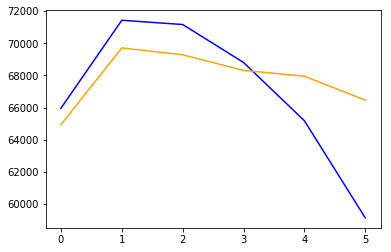

In [32]:
# Modellperformance bewerten
mse = mean_squared_error(ZR_100[-len(predictions_100):], predictions_100)
print('Test MSE: %.3f' % mse)
# line plot of observed vs predicted
plt.plot(ZR_100[-len(predictions_100):], color='blue')
plt.plot(predictions_100, color='orange')
plt.show()

In [33]:
predictions_train_100 = list()
for i in range(len(ZR_N100_TR_I)):
    # make forecast 
    X, y = ZR_N100_TR_I.iloc[i, 0:-1], ZR_N100_TR_I.iloc[i, -1]
    yhat = forecast_lstm(lstm_model_100, 1, X)
    predictions_train_100.append(yhat)

In [34]:
# Skalierung zurücksetzten
predictions_train_100=np.reshape(predictions_train_100,(len(predictions_train_100),1))

In [35]:
predictions_train_100=scaler.inverse_transform(predictions_train_100)

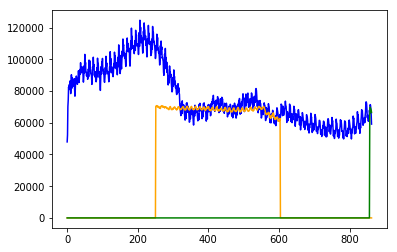

In [36]:
# Verschiebung der Trainingsvorhersage zum Plotten
trainPredictPlot = np.empty_like(ZR_100)
trainPredictPlot=trainPredictPlot.reshape(len(ZR_100))
trainPredictPlot[:]=[0]*len(ZR_100)
predictions_train_100=predictions_train_100.reshape(len(predictions_train_100))
trainPredictPlot[(look_back+look_forward-1):len(predictions_train_100)+(look_back+look_forward-1)] = predictions_train_100

# Verschiebung der Testvorhersage zum Plotten
testPredictPlot = np.empty_like(ZR_100)
testPredictPlot=testPredictPlot.reshape(len(ZR_100))
testPredictPlot[:]=[0]*len(ZR_100)
predictions_100=predictions_100.reshape(len(predictions_100))
testPredictPlot[-len(predictions_100):] = predictions_100

# Plotten der baseline und  der Vorhersagen
plt.plot(ZR_100, color='blue')
plt.plot(trainPredictPlot, color='orange') 
plt.plot(testPredictPlot, color='green')
plt.show()